In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Знакомство с данными

В предоставленном наборе данных имеется информация о 10% скважинных данных (в реальной жизни их может быть менее 1% от площади месторождения!), используя которые, Вам предлагается построить алгоритм, который бы предсказывал значения песчанистости в точках с отсутствующими значениями.

Вход: тренировочный датасет (Training wells.csv) с заполненными значениями песчанистости, а также тестовый датасет (Empty part.csv) с пропущенными значениями песчанистости, для которого вы должны предсказать эти значения. https://disk.yandex.ru/d/M6J9r7yvR8m3GQ?w=1.

Выход: файл с предсказанием песчанитости для тестового файла. В выходном файле последовательность строк сохранить, само предсказание песчанистости добавить четвёртым столбцом в датасет с заголовком столбца NTG, как это сделано в тренировочном датасете. Получившийся файл загрузить в систему.

Критерии оценивания: в качестве метрики оценивания используется метрика RMSE, участники ранжируются относительно значения этой метрики (от меньшего к большему).

In [3]:
df_test = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/YA_PROFI/Полуфинал/Empty_part.csv", sep=",")
df_test

Well    X    Y
0     201-901  201  901
1     201-902  201  902
2     201-903  201  903
3     201-904  201  904
4     201-905  201  905
...       ...  ...  ...
1237  246-926  246  926
1238  246-927  246  927
1239  246-928  246  928
1240  246-929  246  929
1241  246-930  246  930

[1242 rows x 3 columns]

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/YA_PROFI/Полуфинал/Training_wells.csv", sep=",")
df_train

Well    X    Y     NTG
0    201-907  201  907  0.2006
1    201-914  201  914  0.3624
2    201-924  201  924  0.4381
3    202-922  202  922  0.4289
4    202-925  202  925  0.4021
..       ...  ...  ...     ...
133  245-908  245  908  0.2719
134  245-911  245  911  0.3780
135  245-923  245  923  0.4239
136  246-905  246  905  0.4900
137  246-923  246  923  0.3667

[138 rows x 4 columns]

##Статистика

Посмотрим на распределения данных. Оно бимодальное, нескошенное, значит, можно не проводить стандартизацию. Точки в пространстве расположены неплотно, функция их зависимости, скорее всего, нелинейна, поэтому модель должна быть достаточно сложной.

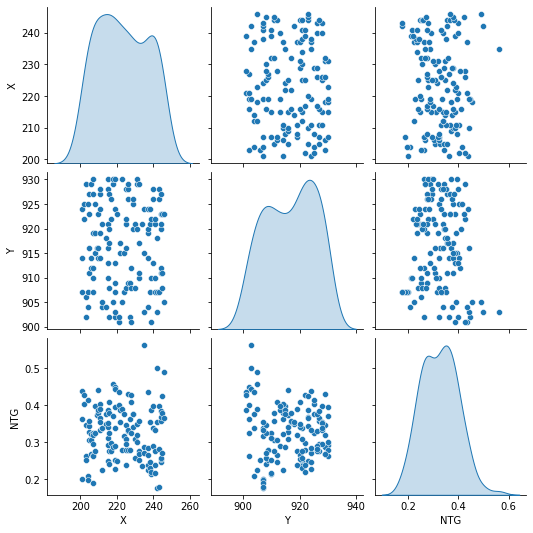

In [5]:
sb.pairplot(df_train, diag_kind='kde')

In [6]:
df_train.describe(include='all')

Well           X           Y         NTG
count       138  138.000000  138.000000  138.000000
unique      138         NaN         NaN         NaN
top     202-922         NaN         NaN         NaN
freq          1         NaN         NaN         NaN
mean        NaN  223.195652  916.630435    0.325720
std         NaN   13.590926    8.765456    0.072432
min         NaN  201.000000  901.000000    0.177000
25%         NaN  211.000000  909.000000    0.270175
50%         NaN  222.500000  917.000000    0.325900
75%         NaN  236.500000  924.000000    0.377475
max         NaN  246.000000  930.000000    0.562500

In [7]:
df_test.describe(include='all')

Well            X            Y
count      1242  1242.000000  1242.000000
unique     1242          NaN          NaN
top     227-925          NaN          NaN
freq          1          NaN          NaN
mean        NaN   223.533816   915.374396
std         NaN    13.250974     8.641061
min         NaN   201.000000   901.000000
25%         NaN   212.000000   908.000000
50%         NaN   224.000000   915.000000
75%         NaN   235.000000   923.000000
max         NaN   246.000000   930.000000

Выше видно, что стандартное отклонение, мин. и макс. значения для столбца Well не считаются, значит, это на самом деле категориальная переменная.

##Проверка на NaN и типы

In [8]:
df_train.isna().values.any()

False

In [9]:
df_test.isna().values.any()

False

NaN в данных нет, значит, никаких доп.операций по заполнению пропущенных значений не потребуется.

In [10]:
df_train.dtypes

Well     object
X         int64
Y         int64
NTG     float64
dtype: object

In [11]:
df_test.dtypes

Well    object
X        int64
Y        int64
dtype: object

Еще одно подтверждение, что в столбце Well на самом деле содержатся нечисловые данные (dtype). Нужно будет их перекодировать.

##Корреляции

Посмотрим, нет ли корреляций между признаками в датасете.

In [12]:
correlation = df_train.corr()
correlation

X         Y       NTG
X    1.000000 -0.026899 -0.055453
Y   -0.026899  1.000000 -0.087215
NTG -0.055453 -0.087215  1.000000

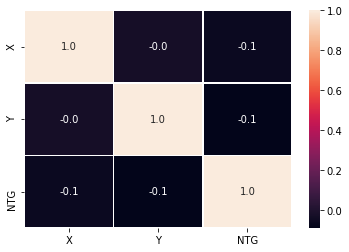

In [13]:
heatmap = sb.heatmap(correlation, annot=True, fmt=".1f", linewidths=.5)
plt.show()

Лишних корреляций нет, все признаки оставляем.

#Подготовка данных

##Перекодирование категориальной переменной

Для этого применим LabelEncoder.

In [14]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df_train.Well = LE.fit_transform(df_train.Well)

In [15]:
df_train

Well    X    Y     NTG
0       0  201  907  0.2006
1       1  201  914  0.3624
2       2  201  924  0.4381
3       3  202  922  0.4289
4       4  202  925  0.4021
..    ...  ...  ...     ...
133   133  245  908  0.2719
134   134  245  911  0.3780
135   135  245  923  0.4239
136   136  246  905  0.4900
137   137  246  923  0.3667

[138 rows x 4 columns]

In [16]:
df_test.Well = LE.fit_transform(df_test.Well)

In [17]:
len(set(df_train.Well))

138

Всего в столбце Well 138 уникальный значений.

##Сплиттинг

Необходимо поделить данные на тренировочную и валидационную часть.

In [18]:
train_dataset = df_train.sample(frac=0.8, random_state=0)
val_dataset = df_train.drop(train_dataset.index)

In [19]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()

train_labels = train_features.pop('NTG')
val_labels = val_features.pop('NTG')

##Нормализация

Нейронная сеть лучше работает с нормализованными данными. Поможем ей в этом.

In [20]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

In [21]:
normalizer = preprocessing.Normalization()

In [22]:
normalizer.adapt(np.array(train_features))

#Строим модели

##Первый вариант

In [23]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

Как мы уже установили выше, простая модель не подойдет для моделирования данных для текущей задачи. В таком случае построим полносвязную модель c несколькими скрытыми слоями, в которой выходной слой содержит 1 нейрон, т.к. мы решаем задачу регрессии.

In [24]:
model_1 = Sequential()

model_1.add(layers.Input(train_features.shape[1]))
model_1.add(layers.Dense(256, activation='sigmoid'))
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(1, activation='linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________


Скомпилируем модель, используя оптимизатор Adam (наиболее универсальный) и функцию потерь mean_squared_error (т.к. решаем задачу регрессии). Дальше обучим на train и оценим на валидацонных данных.

In [25]:
model_1.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history_1 = model_1.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_features, val_labels))

model_1.evaluate(val_features, val_labels, verbose=2)

Epoch 1/10
4/4 [==============================] - 1s 152ms/step - loss: 0.2683 - root_mean_squared_error: 0.5104 - val_loss: 0.1168 - val_root_mean_squared_error: 0.3418
Epoch 2/10
4/4 [==============================] - 0s 14ms/step - loss: 0.0622 - root_mean_squared_error: 0.2456 - val_loss: 0.0705 - val_root_mean_squared_error: 0.2656
Epoch 3/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0730 - root_mean_squared_error: 0.2699 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 4/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0148 - root_mean_squared_error: 0.1182 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2104
Epoch 5/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0289 - root_mean_squared_error: 0.1693 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985
Epoch 6/10
4/4 [==============================] - 0s 13ms/step - loss: 0.0159 - root_mean_squared_error: 0.1255 - val_loss: 0.0114 - val_root_mean_squared

[0.006414246745407581, 0.08008899539709091]

In [26]:
print(history_1.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


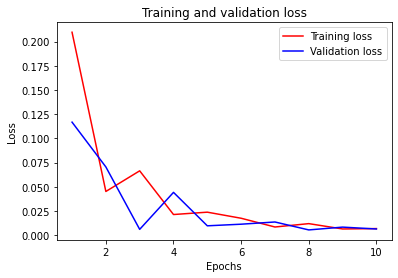

In [27]:
history_dict = history_1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_1.epoch) + 1)

plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

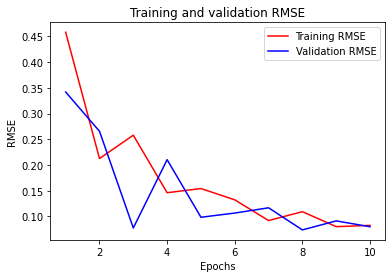

In [28]:
import matplotlib.pyplot as plt

history_dict = history_1.history
root_mean_squared_error = history_dict['root_mean_squared_error']
val_root_mean_squared_error = history_dict['val_root_mean_squared_error']

epochs = range(1, len(history_1.epoch) + 1)

plt.plot(epochs, root_mean_squared_error, 'r', label='Training RMSE')
plt.plot(epochs, val_root_mean_squared_error, 'b', label='Validation RMSE')
plt.title('Training and validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

###Выводы

В целом можно сказать, что показатели функции потерь и метрики ошибки на тренировочной и валидационных выборках отличаются незначительно. Значит, недообучения нет.

Видим, что примерно с 8-й эпохи потери перестают снижаться, а среднеквадратичная ошибка на валидации даже начинает расти. Значит, можно сократить количество эпох.

##Пробуем MAE

Но сначала попробуем другую функцию потерь, MAE, которая менее чувствительна к выбросам в данных.

In [29]:
model_2 = Sequential()

model_2.add(layers.Input(train_features.shape[1]))
model_2.add(layers.Dense(256, activation='sigmoid'))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(1, activation='linear'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_2.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history_2 = model_2.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_features, val_labels))

model_2.evaluate(val_features, val_labels, verbose=2)

Epoch 1/10
4/4 [==============================] - 0s 55ms/step - loss: 1.4035 - root_mean_squared_error: 1.4714 - val_loss: 0.3131 - val_root_mean_squared_error: 0.3197
Epoch 2/10
4/4 [==============================] - 0s 14ms/step - loss: 0.4397 - root_mean_squared_error: 0.4590 - val_loss: 0.4502 - val_root_mean_squared_error: 0.4541
Epoch 3/10
4/4 [==============================] - 0s 14ms/step - loss: 0.3175 - root_mean_squared_error: 0.3543 - val_loss: 0.2620 - val_root_mean_squared_error: 0.2702
Epoch 4/10
4/4 [==============================] - 0s 13ms/step - loss: 0.2741 - root_mean_squared_error: 0.2864 - val_loss: 0.0747 - val_root_mean_squared_error: 0.0886
Epoch 5/10
4/4 [==============================] - 0s 14ms/step - loss: 0.1141 - root_mean_squared_error: 0.1329 - val_loss: 0.2082 - val_root_mean_squared_error: 0.2154
Epoch 6/10
4/4 [==============================] - 0s 13ms/step - loss: 0.1529 - root_mean_squared_error: 0.1756 - val_loss: 0.1258 - val_root_mean_squared_

[0.08933806419372559, 0.10472399741411209]

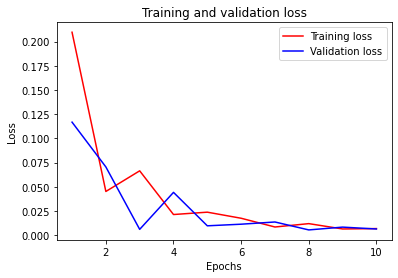

In [31]:
history_dict = history_1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_2.epoch) + 1)

plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

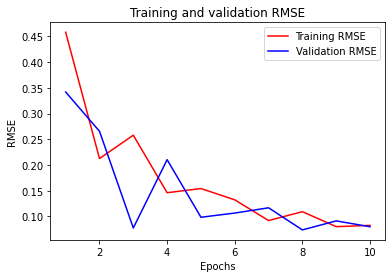

In [32]:
import matplotlib.pyplot as plt

history_dict = history_1.history
root_mean_squared_error = history_dict['root_mean_squared_error']
val_root_mean_squared_error = history_dict['val_root_mean_squared_error']

epochs = range(1, len(history_2.epoch) + 1)

plt.plot(epochs, root_mean_squared_error, 'r', label='Training RMSE')
plt.plot(epochs, val_root_mean_squared_error, 'b', label='Validation RMSE')
plt.title('Training and validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

###Выводы

Другая функция потерь не улучшила показатели. Посмотрев на графики, можно сказать, что ситуация с эпохами идентична первой модели: их число можно сократить.

#Итоговая модель

В качестве лучшей выберем первую модель с меньшим числом эпох обучения (8 эпох).

In [33]:
model = Sequential()

model.add(layers.Input(train_features.shape[1]))
model.add(layers.Dense(256, activation='sigmoid'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(train_features, train_labels,
                    epochs=8,
                    batch_size=32,
                    validation_data=(val_features, val_labels))

model.evaluate(val_features, val_labels, verbose=2)

Epoch 1/8
4/4 [==============================] - 0s 55ms/step - loss: 0.1517 - root_mean_squared_error: 0.3891 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1605
Epoch 2/8
4/4 [==============================] - 0s 14ms/step - loss: 0.0550 - root_mean_squared_error: 0.2306 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0723
Epoch 3/8
4/4 [==============================] - 0s 13ms/step - loss: 0.0294 - root_mean_squared_error: 0.1630 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 4/8
4/4 [==============================] - 0s 12ms/step - loss: 0.0156 - root_mean_squared_error: 0.1247 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1800
Epoch 5/8
4/4 [==============================] - 0s 15ms/step - loss: 0.0208 - root_mean_squared_error: 0.1435 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 6/8
4/4 [==============================] - 0s 13ms/step - loss: 0.0194 - root_mean_squared_error: 0.1391 - val_loss: 0.0047 - val_root_mean_squared_error:

[0.009989017620682716, 0.0999450758099556]

Итоговые значения RMSE:
*   для train 0.0836 
*   для val 0.0999


#Предсказания и запись аутпута

In [35]:
x_test = df_test.values

In [36]:
x_test

array([[   0,  201,  901],
       [   1,  201,  902],
       [   2,  201,  903],
       ...,
       [1239,  246,  928],
       [1240,  246,  929],
       [1241,  246,  930]])

Предскажем значения NTG.

In [37]:
predictions = model.predict(x_test)

In [38]:
predictions

array([[0.2190982 ],
       [0.21918936],
       [0.21928473],
       ...,
       [0.10439698],
       [0.10492785],
       [0.10543872]], dtype=float32)

Сделаем глубокую копию тестового датасета.

In [39]:
df_output = df_test.copy(deep=True)

In [40]:
len(predictions)

1242

In [41]:
df_test.shape

(1242, 3)

Имеем одинаковую размерность для array с предсказаниями и датасета. Теперь сделаем из array список и "выпрямим" его.

In [42]:
predictions_lst = predictions.tolist()
flatten = [i[0] for i in predictions_lst]

In [43]:
len(flatten)

1242

Длина списка корректная. Добавим полученный список как новый столбец датафрейма.

Перекодируем элементы столбца Well, которые мы обработали с помощью LabelEncoder.

In [44]:
df_output['Well'] = LE.inverse_transform(df_output['Well'])

In [45]:
df_output['NTG'] = flatten

In [46]:
df_output

Well    X    Y       NTG
0     201-901  201  901  0.219098
1     201-902  201  902  0.219189
2     201-903  201  903  0.219285
3     201-904  201  904  0.219384
4     201-905  201  905  0.219488
...       ...  ...  ...       ...
1237  246-926  246  926  0.103274
1238  246-927  246  927  0.103846
1239  246-928  246  928  0.104397
1240  246-929  246  929  0.104928
1241  246-930  246  930  0.105439

[1242 rows x 4 columns]

Запишем в файл.

In [47]:
from google.colab import files
df_output.to_csv('prediction.csv', index=False) 
files.download('prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>